# Unsupervised Clustering with KMeans, Hierarchical Clustering, and Gaussian Mixture Model (GMM)

In this notebook, we will compare three different clustering algorithms to evaluate their performance using two important clustering evaluation metrics:
- **Silhouette Score**: Measures how similar each point is to its own cluster compared to other clusters. Higher values indicate better-defined clusters.
- **Davies-Bouldin Score**: Measures the average similarity ratio of each cluster with the cluster that is most similar to it. Lower values indicate better clustering.

## Algorithms Used:

### 1. KMeans Clustering
KMeans is a popular clustering algorithm that partitions the dataset into `k` clusters based on the distances between data points and the centroids of the clusters. The algorithm iteratively adjusts the centroids and assigns each point to the nearest centroid until convergence.

### 2. Hierarchical Clustering
Hierarchical clustering builds a tree of clusters by either merging smaller clusters (agglomerative) or dividing larger clusters (divisive). It doesn’t require the number of clusters to be pre-defined and is useful for hierarchical relationships in the data.

### 3. Gaussian Mixture Model (GMM)
Gaussian Mixture Model assumes that the data is generated from a mixture of several Gaussian distributions. It tries to find the best-fitting distribution and assigns points to the clusters based on the probability of belonging to each distribution.

## Clustering Comparison

We will apply the following clustering algorithms to the dataset and evaluate their performance using the **Silhouette Score** and **Davies-Bouldin Score**.

In [19]:
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import davies_bouldin_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing: Loading and Cleaning

In this section, we will load the dataset, clean the data by handling missing values and removing unnecessary columns, and then combine the training and test data for further preprocessing.

## 2. Load the Dataset

We begin by running the necessary script to load the dataset. This will provide us with both the training and test datasets that we will clean and prepare for analysis.

Then we clean the data further by dropping columns we dont need, this improves the models accuracy

lastly we combine the data in order to begin feature engineering


In [20]:

# Load the dataset
%run dataInfo.ipynb

#clean the data
cleanTest = test_df
cleanTrain = train_df #doesn't have asd/class

# Drop train class column
cleanTrain = cleanTrain.drop(columns=['Class/ASD'])
cleanTrain = cleanTrain.loc[:, ~cleanTrain.columns.str.startswith('relation_')]
cleanTest = cleanTest.loc[:, ~cleanTest.columns.str.startswith('relation_')]


# Combine train and test data for preprocessing
combined_df = pd.concat([cleanTrain, cleanTest], axis=0)
combined = combined_df.dropna()

# Feature Engineering: Creating Composite Features

In this section, we will engineer several composite features that combine existing features to potentially enhance the performance of our machine learning model. The new features include averages, interactions, and polynomial transformations of the data.

## 3. Create a New Feature: `mean_A_score`

We begin by creating a new feature, `mean_A_score`, which is the average of the scores from `A1_Score` to `A10_Score`. This feature consolidates the information from multiple individual scores into a single metric.

## 4. Create a New Feature: `age_x_mean_A`

Then we made a new feature, `age_x_mean_A`, which is the person’s age times their `mean_A_score`. This interaction term captures the combined effect of a person's age and average score, potentially revealing more complex relationships in the data.

## 5. Create a New Feature: `age_squared`

After that, we created `age_squared` in order to capture non-linear effects of age on the target variable. By squaring the age, we allow the model to detect patterns where the relationship between age and the target might not be linear.

## 6. Create a New Feature: `mean_A_score_squared`

Lastly, we made `mean_A_score_squared` in order to capture non-linear relationships between the `mean_A_score` and the target variable. Squaring the average score allows the model to learn complex interactions and patterns that might improve prediction accuracy.


In [21]:
#Engineer Composite Features

# Create a new feature 'mean_A_score' by averaging the scores of A1 to A10
score_cols = [f"A{i}_Score" for i in range(1, 11)]
combined['mean_A_score'] = combined[score_cols].mean(axis=1)

# score times age
combined['age_x_mean_A'] = combined['age'] * combined['mean_A_score']

# Polynomial features (squared terms)
combined['age_squared'] = combined['age'] ** 2
combined['mean_A_score_squared'] = combined['mean_A_score'] ** 2


# Clustering Analysis

In this section, we will run different clustering algorithms on the dataset and evaluate their performance using two common clustering metrics: the Silhouette Score and the Davies-Bouldin Score.

## 1. Hierarchical Clustering

We begin by performing hierarchical clustering using the AgglomerativeClustering algorithm. The number of clusters is set to 3, and the Ward linkage method is used. After fitting the model, we evaluate its performance with the Silhouette Score and the Davies-Bouldin Score.

- **Silhouette Score for Hierarchical Clustering**: This score indicates how similar the data points within a cluster are.
- **Davies-Bouldin Score for Hierarchical Clustering**: This score measures the average similarity ratio of each cluster with the one that is most similar to it.

## 2. KMeans Clustering

Next, we run KMeans clustering with 3 clusters and evaluate its performance using the same metrics: Silhouette Score and Davies-Bouldin Score.

- **Silhouette Score for KMeans**: This score measures the compactness and separation of the clusters.
- **Davies-Bouldin Score for KMeans**: This score measures the separation between clusters.

## 3. Gaussian Mixture Model (GMM) Clustering

Finally, we apply the Gaussian Mixture Model (GMM) with 6 components to see how it performs with a different number of clusters. Again, we evaluate the clustering using the Silhouette Score and Davies-Bouldin Score.

- **Silhouette Score for GMM**: This score provides insight into the quality of the clusters formed by the GMM.
- **Davies-Bouldin Score for GMM**: This score provides insight into the separation between clusters formed by the GMM.

## Conclusion

In this analysis, we have applied three different clustering algorithms to the dataset: Hierarchical Clustering, KMeans, and Gaussian Mixture Model (GMM). We evaluated the performance of each clustering technique using the Silhouette Score and the Davies-Bouldin Score, which give us a sense of how well the clusters are formed. Based on these scores, we can determine which clustering algorithm best fits the data.


In [22]:
# run the hierarchical clustering
model = AgglomerativeClustering(n_clusters=3, linkage='ward')  # Choose the number of clusters you want (e.g., 3)
combined['hierarchical_cluster'] = model.fit_predict(combined)
hierarchical_siloutte = silhouette_score(combined, combined['hierarchical_cluster'])
print(f"Silhouette Score for Hierarchical Clustering: {hierarchical_siloutte}")
db_hierarchical = davies_bouldin_score(combined, combined['hierarchical_cluster'])
print(f"Davies-Bouldin Score for Hierarchical Clustering: {db_hierarchical}")
combined['hierarchical_cluster'] = combined['hierarchical_cluster']

#run the clustering
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans_clusters = kmeans.fit_predict(combined)
kmeans_silhouette = silhouette_score(combined, kmeans_clusters)
print(f"Silhouette Score for KMeans: {kmeans_silhouette}")
db_kmeans = davies_bouldin_score(combined, kmeans_clusters)
print(f"Davies-Bouldin Score for KMeans: {db_kmeans}")
combined['kmeans_cluster'] = kmeans_clusters

# Let's say you want to try different cluster numbers (e.g., 3 or 4)
gmm = GaussianMixture(n_components=6, random_state=42)  # n_components is the number of clusters
gmm_clusters = gmm.fit_predict(combined)  # Fit the model and predict cluster labels
gmm_silhouette = silhouette_score(combined, gmm_clusters)
print(f"Silhouette Score for GMM: {gmm_silhouette}")
db_gmm = davies_bouldin_score(combined, gmm_clusters)
print(f"Davies-Bouldin Score for GMM: {db_gmm}")
combined['gmm_cluster'] = gmm_clusters

Silhouette Score for Hierarchical Clustering: 0.630831569464452
Davies-Bouldin Score for Hierarchical Clustering: 0.518154942820026
Silhouette Score for KMeans: 0.6421949053751135
Davies-Bouldin Score for KMeans: 0.5073488222631952
Silhouette Score for GMM: 0.5630173411349887
Davies-Bouldin Score for GMM: 0.5241656981437921


# Cluster Summary

In this section, we will examine the summary statistics for each cluster produced by the different clustering algorithms. We will calculate the mean values for each feature within each cluster to understand the characteristics of the clusters generated by Hierarchical Clustering, KMeans, and Gaussian Mixture Models (GMM).

## 1. Hierarchical Cluster Summary

The summary for the hierarchical clustering provides the mean values of each feature for each cluster. This allows us to analyze the central tendency of the data points within each cluster, helping us understand the nature of the clusters formed.

## 2. KMeans Cluster Summary

Similarly, the KMeans clustering results are summarized by calculating the mean values of each feature within each cluster. This summary gives us an overview of the typical values of the features for the data points in each cluster.

## 3. GMM Cluster Summary

The GMM cluster summary provides the mean values of each feature for each cluster formed by the Gaussian Mixture Model. This summary allows us to examine the characteristics of the clusters generated by the probabilistic model.

## Conclusion

By reviewing the cluster summaries for each algorithm, we gain insight into the average feature values that define each cluster. This helps in understanding the key differences between the clusters formed by Hierarchical Clustering, KMeans, and GMM, and can guide further analysis or interpretation of the clustering results.


In [23]:
# Print the cluster labels
kmeans_cluster_summary = combined.groupby('kmeans_cluster').mean()
gmm_cluster_summary = combined.groupby('gmm_cluster').mean()
cluster_summary = combined.groupby('hierarchical_cluster').mean()  # Shows mean of each feature per cluster


#Print cluster summaries
print("Hierarchical Cluster Summary:")
print(cluster_summary)

print("KMeans Cluster Summary:")
print(kmeans_cluster_summary)

print("GMM Cluster Summary:")
print(gmm_cluster_summary)

Hierarchical Cluster Summary:
                      A1_Score  A2_Score  A3_Score  A4_Score  A5_Score  \
hierarchical_cluster                                                     
0                     0.619048  0.761905  0.619048  0.571429   0.52381   
1                     0.555556  0.592593  0.574074  0.444444   0.50000   
2                     0.576000  0.504000  0.408000  0.392000   0.41600   

                      A6_Score  A7_Score  A8_Score  A9_Score  A10_Score  ...  \
hierarchical_cluster                                                     ...   
0                     0.666667  0.523810  0.619048  0.666667   0.714286  ...   
1                     0.370370  0.444444  0.629630  0.555556   0.685185  ...   
2                     0.272000  0.392000  0.496000  0.512000   0.608000  ...   

                      country_of_res_United Kingdom  \
hierarchical_cluster                                  
0                                          0.047619   
1                                

# Dimensionality Reduction and Visualization

In this section, we reduce the dimensionality of the dataset to two principal components using Principal Component Analysis (PCA) and visualize the clustering results from Hierarchical Clustering, KMeans, and Gaussian Mixture Models (GMM) in a 2D plot.

## 1. PCA Transformation

We apply PCA to reduce the dataset's dimensions to two principal components, which helps in visualizing the data in a 2D space. By doing so, we can capture the most important features while simplifying the dataset, making it easier to observe the separation between clusters.

## 2. Adding Cluster Labels

After applying PCA, we add the cluster labels (for Hierarchical, KMeans, and GMM) back into the transformed dataset. This allows us to color the points based on their respective cluster assignments, making it easier to observe how well the clusters are separated in the 2D space.

## 3. Visualizing the Clusters

We create three side-by-side scatter plots to visualize the results of each clustering algorithm:

- **Hierarchical Clustering (PCA Projection)**: This plot shows how the clusters formed by Hierarchical Clustering are distributed in the 2D PCA space.
- **KMeans Clustering (PCA Projection)**: This plot visualizes the clusters formed by the KMeans algorithm in the 2D PCA space.
- **GMM Clustering (PCA Projection)**: This plot displays the clusters formed by the Gaussian Mixture Model (GMM) in the 2D PCA space.

## Conclusion

By reducing the dimensionality of the dataset to two components and visualizing the clusters, we can more easily assess the separation and distribution of data points based on their cluster labels. This visualization helps in understanding how each clustering algorithm performs in a reduced feature space and whether the clusters are well-separated or not.


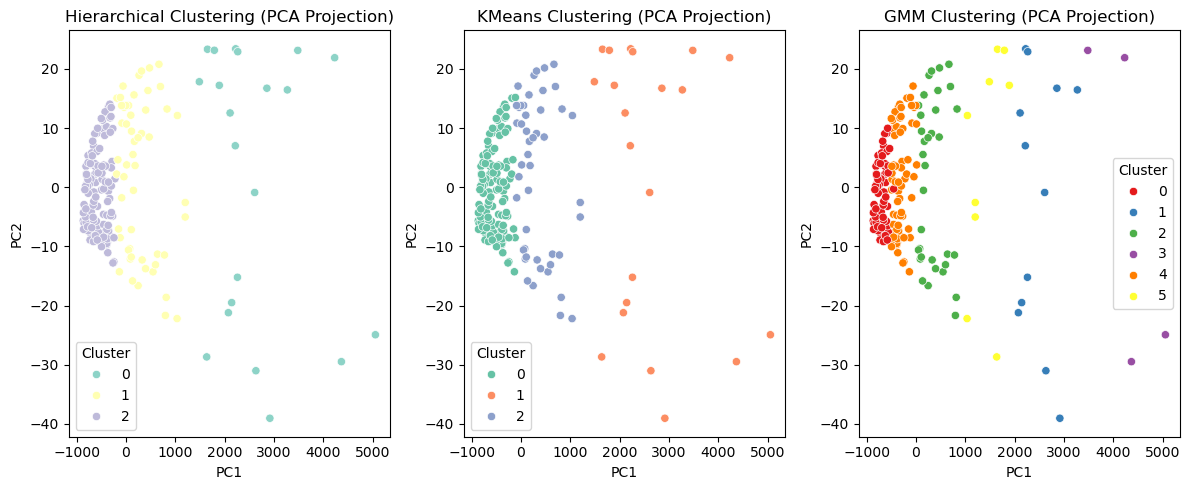

In [24]:
# Reduce dimensionality
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(combined.drop(columns=['kmeans_cluster', 'gmm_cluster']))

# Convert to DataFrame
pca_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2'])

# Add cluster labels back in
if 'kmeans_cluster' in combined.columns:
    pca_df['kmeans_cluster'] = combined['kmeans_cluster'].values
if 'gmm_cluster' in combined.columns:
    pca_df['gmm_cluster'] = combined['gmm_cluster'].values
if 'hierarchical_cluster' in combined.columns:
    pca_df['hierarchical_cluster'] = combined['hierarchical_cluster'].values

#kmeans
plt.figure(figsize=(12, 5))

#Hierarchical
plt.subplot(1, 3, 1)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='hierarchical_cluster', palette='Set3')
plt.title('Hierarchical Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# KMeans
plt.subplot(1, 3, 2)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='kmeans_cluster', palette='Set2')
plt.title('KMeans Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

# GMM
plt.subplot(1, 3, 3)
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='gmm_cluster', palette='Set1')
plt.title('GMM Clustering (PCA Projection)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Cluster')

plt.tight_layout()
plt.show()



# Unsupervised Clustering: Latent Profiles Exploration

In this section, we explore the latent profiles identified using three unsupervised clustering techniques:
- **Hierarchical Clustering**
- **KMeans Clustering**
- **Gaussian Mixture Models (GMM)**

We present the key patterns and profiles discovered for each clustering method by analyzing the **average feature values per cluster**.

---

## Hierarchical Clustering: Profiles Overview

The hierarchical clustering analysis revealed **3 latent clusters**, each showing distinct patterns in the features.

| Cluster | Highlights |
|---------|------------|
| **Cluster 0** | - Higher mean A scores across most attributes (e.g., A1, A2, A9, A10).<br> - Older age group (Mean Age × A Score: ~36.8).<br> - Higher prevalence from the United States (19%). |
| **Cluster 1** | - Moderate A scores across most attributes.<br> - Younger demographic (Mean Age × A Score: ~17.8).<br> - Slightly more representation from the United Kingdom (13%). |
| **Cluster 2** | - Lower overall A scores.<br> - Youngest demographic (Mean Age × A Score: ~7.8).<br> - Very low scores across socio-demographics. |

This indicates that **Cluster 0 represents a more severe or older profile**, while **Cluster 2 captures a younger and potentially lower-risk group**.

---

## KMeans Clustering: Profiles Overview

The KMeans clustering revealed **3 clusters**, largely aligning with the hierarchical clustering insights but with slight variations.

| Cluster | Highlights |
|---------|------------|
| **Cluster 0** | - Lower mean A scores across most variables.<br> - Younger group (Age × A Score: ~8.1).<br> - Lower representation of the United States and United Kingdom. |
| **Cluster 1** | - Highest A scores across most domains.<br> - Older individuals (Age × A Score: ~36.7).<br> - Highest share of participants from the United States (19%). |
| **Cluster 2** | - Mid-range A scores.<br> - Age in between clusters 0 and 1 (~18.5).<br> - Higher representation from the United Kingdom. |

**Cluster 1 appears as the dominant severe profile, while Cluster 0 aligns to a lower-risk, younger cluster**.

---

## Gaussian Mixture Model (GMM): Profiles Overview

GMM clustering uncovered **6 latent profiles**, revealing more nuanced subgroups.

| Cluster | Highlights |
|---------|------------|
| **Cluster 0** | - Low to moderate A scores.<br> - Young group (Age × A Score: ~6.2). |
| **Cluster 1** | - High A2 Score but generally balanced other scores.<br> - Older individuals (Age × A Score: ~32.3). |
| **Cluster 2** | - Mid-level A scores.<br> - Medium age group (~17.4). |
| **Cluster 3** | - Very high A1, A9, and A10 scores.<br> - Oldest group (Age × A Score: ~47.6).<br> - Very distinct outlier profile. |
| **Cluster 4** | - Moderate A scores, with lower A4 and A6.<br> - Slightly older than cluster 0 (~11.9). |
| **Cluster 5** | - Elevated A scores across most metrics.<br> - Older group (~29.9).<br> - High A6, A7, and A10 scores. |

The GMM model shows that **Cluster 3 stands out as a high-risk, older profile with extreme scores**, while **Cluster 0 and 4 capture younger, lower-risk groups**.

---

## Cross-Cluster Observations

- Across models, **higher A scores consistently correlate with older age groups**.
- The **United States and United Kingdom show higher representation in the higher-score clusters**, especially in Hierarchical and KMeans.
- **GMM offers the most granularity, revealing unique clusters such as Cluster 3 (potential high-risk older outliers)** that are not as distinctly identified by the other methods.

---

## Next Steps

To further validate these clusters:
- Perform **SHAP analysis on any supervised models built from these clusters**.
- Explore **t-SNE or UMAP visualizations** to visually inspect cluster separability.
- Investigate **feature importance driving cluster assignment** using decision tree surrogates.



Final Latent response profiles with the data outputted